In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import json
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.utils import preprocess_text, prepare_labels
from src.preprocessor import DatasetModel, VectorDictionaries, DataVector, generate_batches
from src.models import BaselineModel
from src.metrics import calc_jaccard
from src.settings import logreg_params

import warnings
warnings.filterwarnings('ignore')

In [28]:
train_df = pd.read_csv('../coleridgeinitiative-show-us-the-data/train.csv')
train_files_path = '../coleridgeinitiative-show-us-the-data/train'
test_files_path = '../coleridgeinitiative-show-us-the-data/test'

# 0. Подготовка текста

In [29]:
# добавление json в csv
def read_append_return(filename, train_files_path=train_files_path, output='text', keep_list=False):
    json_path = os.path.join(train_files_path, (filename + '.json'))
    headings = []
    contents = []
    combined = []
    with open(json_path, 'r') as f:
        json_decode = json.load(f)
        for data in json_decode:
            headings.append(data.get('section_title'))
            contents.append(data.get('text'))
            combined.append(data.get('section_title'))
            combined.append(data.get('text'))

    if not keep_list:
        headings = ' '.join(headings)
        contents = ' '.join(contents)
        combined = '\n\n '.join(combined)

    if output == 'text':
        return contents
    elif output == 'head':
        return headings
    else:
        return combined

In [24]:
train_df.head()

,Id,pub_title,dataset_title,dataset_label,cleaned_label
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study


In [30]:
train_df['text'] = train_df['Id'].apply(read_append_return) # загружаем текст статей

In [35]:
train_df['cleaned_label_test'] = prepare_labels(data=train_df)

In [37]:
train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)

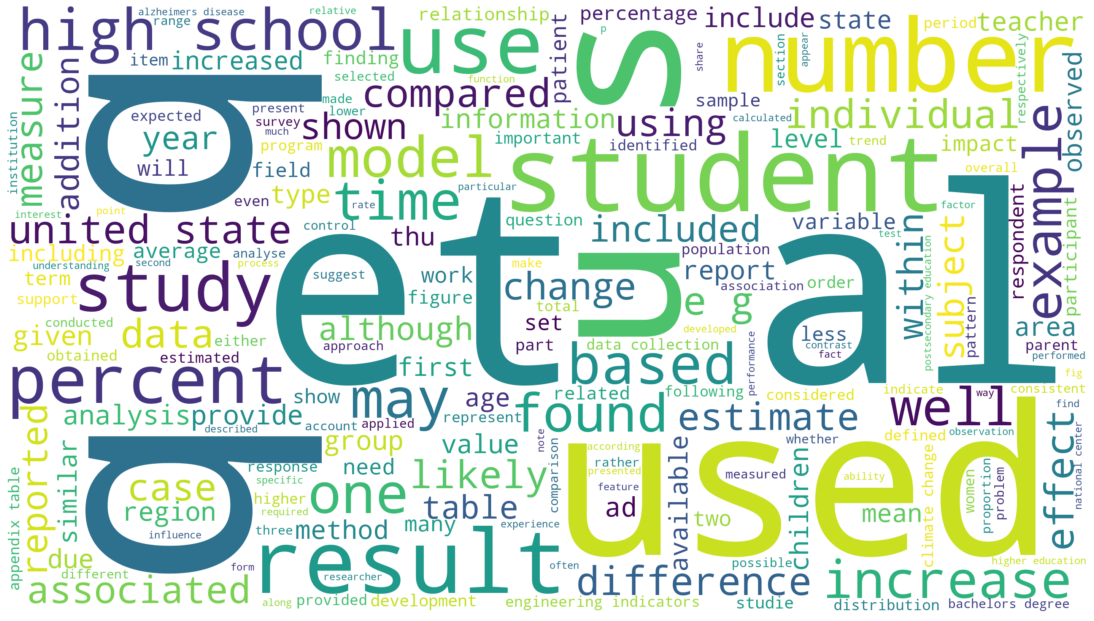

In [42]:
text = ' '.join(train_df['cleaned_text'].sample(frac=0.3))
wordcloud = WordCloud(background_color='white', width=2560, height=1440).generate(text)

barplot_dim = (15, 15)
ax = plt.subplots(figsize=barplot_dim, facecolor='w')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [32]:
train_df['cleaned_label'].nunique()

130

In [44]:
train_df['cleaned_text'].apply(lambda x: len(x.split())).describe()

count    1.966100e+04
mean     8.340936e+03
std      2.548595e+04
min      6.300000e+01
25%      3.571000e+03
50%      5.125000e+03
75%      7.502000e+03
max      1.658494e+06
Name: cleaned_text, dtype: float64

In [46]:
train_df.drop(['dataset_title', 'dataset_label', 'cleaned_label', 'text'], axis=1, inplace=True)

In [48]:
train_df['pub_title'].apply(lambda x: len(x.split())).describe()

count    19661.000000
mean        12.912009
std          4.701127
min          1.000000
25%         10.000000
50%         12.000000
75%         16.000000
max         84.000000
Name: pub_title, dtype: float64

# 1. Бэйзлайн

Попробуем для начала сматчить по названию статьи. Воспользуемся TF-Idf, N_grams и логистической регрессией.

In [ ]:
X_train, x_valid, Y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.35, random_state=43)